# **EX 2 - PnP and RANSAC**

## **2.1** Create point cloud for image_pair<sub>0</sub> and image_pair<sub>1</sub>
Reading camera matrices:

In [12]:
import os
from utils import *
import matplotlib.pyplot as plt
import random
DATA_PATH = r'../data/dataset05/sequences/05/'
# get camera matrices
K, M1, M2 = read_cameras(DATA_PATH)
P = K @ M1
Q = K @ M2
logging.info("Loaded Kitti camera calibrations")

2021-09-30 11:59:37,713 INFO Loaded Kitti camera calibrations


Defining the data structe:
1. Every image has its key points and descriptors. This are kept throughout the code. Only the matches, are later changed.
    an image is a dict with follwing key-value pairs:
    "idx": idx,\
    "img": img, \
    "kpts":kpts, \
    "desc": desc
2. An image pair is a dict, defined with the following key-value pairs:\
            "left_img_idx": img1_dict["idx"],\
            "right_img_idx": img2_dict["idx"],\
            "kpts1": img1_dict["kpts"],\
            "desc1": img1_dict["desc"],\
            "kpts2": img2_dict["kpts"],\
            "desc2": img2_dict["desc"],\
            "left_img": img1_dict["img"],\
            "right_img": img2_dict["img"],\
            "method": method for outliers filtering,\
            "inliers": macth inliers,\
            "outliers":  match outliers

Generating point clouds for image pair of frame 0 and for image pair of frame 1

2021-09-30 12:17:45,696 INFO ==== Answer [2.1]:=====
2021-09-30 12:17:45,795 INFO calculated 3D point cloud for image pair 0
2021-09-30 12:17:45,897 INFO calculated 3D point cloud for image pair 1
2021-09-30 12:17:45,899 INFO ===== Answer [2.2] =====
2021-09-30 12:17:45,949 INFO matched features in frame seq: left[0], left[1]
2021-09-30 12:17:45,950 INFO ===== Answer [2.3] =====
2021-09-30 12:17:45,953 INFO inliers frame 0: 206; inliers frame 1: 206
2021-09-30 12:17:45,992 INFO 3D world coordinates from frame 0:
2021-09-30 12:17:45,993 INFO [[ -6.56347104  -5.88574486  -7.59954477 -10.29071279]
 [  0.71918526   0.58592782   0.16916665  -2.54261128]
 [ 36.63330244  31.65138546  63.30241667 109.90420583]]
2021-09-30 12:17:45,994 INFO using frame0 points to as TRUE 3D position for PnP calculation on frame 1
2021-09-30 12:17:45,995 INFO PnP succeeded
2021-09-30 12:17:45,998 INFO frame left 1 PnP solution: R=[[ 5.76693652e-02 -9.11417204e-01  4.07422292e-01]
 [ 9.98335600e-01  5.28621970e-0

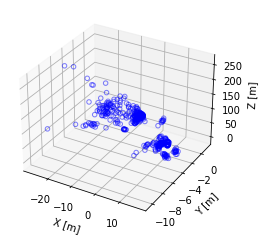

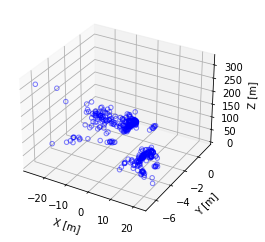

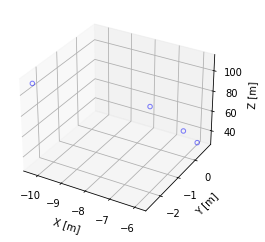

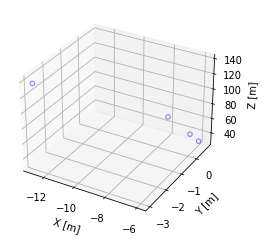

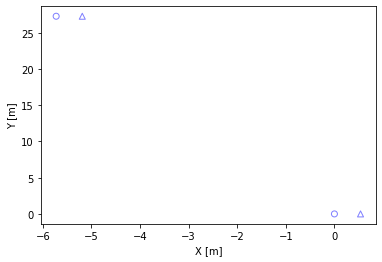

-1

In [16]:
img_pairs=[]
logging.info("==== Answer [2.1]:=====")
point_cloud = []
left_imgs = []
right_imgs = []
for idx in range(0,2):
    img1_dict, img2_dict = read_images_and_detect_keyPts(idx, DATA_PATH, plot=False)
    left_imgs.append(img1_dict)
    right_imgs.append(img2_dict)
    img_pairs.append(create_img_pair_from_img_dicts(left_imgs[idx], right_imgs[idx]))
    # match key points
    img_pairs[idx] = match_rectified_images(img_pairs[idx], feature_matcher="bf", cumsumThres = 0.88, plot=False)
    draw_img_pair_kpts(img_pairs[idx], title="matched pairs:[left {}, right {}]")

    # get point cloud
    point_cloud.append(generate_point_cloud(img_pairs[idx], P, Q, plot=True))
    logging.info("calculated 3D point cloud for image pair {}".format(idx))


# match points in two left images
print("\n")
logging.info("===== Answer [2.2] =====")
left_cam_pairs = []
for idx in range(0, 1):
    left_cam_pairs.append(create_img_pair_from_img_dicts(left_imgs[idx], left_imgs[idx + 1])) 
    left_cam_pairs[idx] = match_images(left_cam_pairs[idx], matcher="bf", cumsumThres=0.88, plot=False)
    draw_img_pair_kpts(left_cam_pairs[idx], title="matched seq:[left {}, left {}]")
    logging.info("matched features in frame seq: left[{}], left[{}]".format(idx, idx+1))

print("\n")
logging.info("===== Answer [2.3] =====")
# finding kpts that were matches between subsequant left image frames, and between left and right image frames
# thest are matches that are found in: inliers[left0, right0]; inliers[left0, left1]; inliers[left1, right1]
for frame_idx in range(0, 1):
    left_cam_pairs[frame_idx], img_pairs = get_consistent_matches_between_frames(left_cam_pairs[frame_idx], img_pairs)


# randomly select 4 key-points that were matched on all four images (2 image pairs from frame0 and frame 1)
idx = 0
# building point cloud only from key points that are matched on all four images (2 image pairs from frame0 and frame1)
success = False
while not success:
    points_idx = random.sample(range(len(left_cam_pairs[idx]["inliers"])), 4)
    world_points = generate_point_cloud(img_pairs[idx], P, Q, inliers_idx=points_idx, plot=True)
    generate_point_cloud(img_pairs[idx+1], P, Q, inliers_idx=points_idx, plot=True)

    logging.info("3D world coordinates from frame 0:")
    logging.info(world_points)
    logging.info("using frame0 points to as TRUE 3D position for PnP calculation on frame 1")
    
    image_points = np.array([img_pairs[1]["kpts1"][ind].pt for ind in points_idx])

    # calculate PnP:
    success, R1, t1 = cv2.solvePnP(objectPoints=world_points.transpose(), 
                        imagePoints=image_points,
                        cameraMatrix=P[:,:3], 
                        distCoeffs=np.zeros((4,1)),
                        flags=cv2.SOLVEPNP_P3P
    )
    try:
        R1, jacobian = cv2.Rodrigues(R1)
        success=True
        logging.info("PnP succeeded")
    except Exception as exception:
        logging.info("PnP failed")
        logging.warning(exception)
        success=False



# Xc = RXw + T = [R | T]
# To find camera position, we have to find Xw such that Xc = 0
# Xw = inv(R)Xc - inv(R)T = [inv(R) | -inv(R)T]
# Because R is unitary: inv(R) = R':
# Xw = R'Xc - R'T = [R' | -R'T]

logging.info("frame left {} PnP solution: R={}".format(1, R1))
logging.info("frame left {} PnP solution: T={}".format(1, t1.transpose()))

camPos_left = []
camRot_left = []
camPos_right = []
camRot_right = []
yaw_pitch_roll = []

camPos_left.append(np.zeros((3,1)))
camRot_left.append(M1[:, :3])

camPos_left.append(-R1.transpose() @ t1)
camRot_left.append(R1.transpose())
# get camera rotation:
yaw_pitch_roll.append(cv2.decomposeProjectionMatrix(projMatrix=np.hstack((camRot_left[0], camPos_left[0])), cameraMatrix=K)[6])

fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
for idx in range(0, 2):
    # calculating position of right camera
    camPos_right.append(camPos_left[idx] - M2[:, -1].reshape(-1, 1))
    camRot_right.append(camRot_left[idx])
    yaw_pitch_roll.append(cv2.decomposeProjectionMatrix(projMatrix=np.hstack((camRot_left[idx], camPos_left[idx])), cameraMatrix=K)[6])
    logging.info("frame {} LEFT:  cam Pos={}[m]; yaw={}[deg], pitch={}[deg], roll={}[deg]".format(idx, camPos_left[idx].transpose()[0], yaw_pitch_roll[idx][0], yaw_pitch_roll[0][1], yaw_pitch_roll[idx][2]))
    logging.info("frame {} RIGHT: cam Pos={}[m]; yaw={}[deg], pitch={}[deg], roll={}[deg]".format(idx, camPos_right[idx].transpose()[0], yaw_pitch_roll[idx][0], yaw_pitch_roll[idx][1], yaw_pitch_roll[idx][2]))
    plt.scatter(camPos_left[idx][0], camPos_left[idx][2], marker='o', alpha=0.5, facecolors="None", color='blue')
    plt.scatter(camPos_right[idx][0], camPos_right[idx][2], marker='^', alpha=0.5, facecolors="None", color='blue')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
# ax.set_zlabel('Z [m]')

#

plt.show()
cv2.waitKey(1)